In [2]:
import numpy as np
from torch_geometric.data import Data
import json
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import os
from core.datasetclass import HydrogelDataset
from core.model_graphnet import EncodeProcessDecode
import numpy as np
from tqdm import tqdm
from core.utils import * 
import h5py
import meshio
import time
from run_rollout import rollout
device = "cuda"



In [32]:
data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/dataset/linear_hydrogel"
# data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/dataset/linear_extr_testcases"
# output_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/rollout/{test_on}"
# paraview_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/rollout/{test_on}"

time_window = 1
model_dir = r"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/trained_model/2025-05-22T11h43m17s/model_checkpoint"
dataset = HydrogelDataset(data_dir, add_targets= True, split_frames=True, add_noise = False, time_window=time_window)
data = dataset[49]
model = EncodeProcessDecode(node_feature_size = 7,
                            mesh_edge_feature_size = 7,
                            output_size = 3,
                            latent_size = 128,
                            timestep=1e-5,
                            time_window=time_window,
                            device=device,
                            message_passing_steps = 15)
model.to(device)
model.load_model(model_dir)
model.eval()
model = torch.compile(model)
# Training loop
output = rollout(model, data, time_window)

Rollout: 100%|██████████| 98/98 [00:02<00:00, 36.50it/s]


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_result(
    mesh_pos: np.array,
    node_connectivity: np.array,
    pred_displacement: np.array,
    gt_displacement: np.array,
    pred_chem_pot: np.array,
    gt_chem_pot: np.array,
    desc: str
):
    """
    Plots predicted vs ground truth displacement fields and chemical potential.

    Parameters:
        mesh_pos (np.array): Node positions (N, 2)
        node_connectivity (np.array): Triangular connectivity (M, 3)
        displacement_pred (np.array): Predicted displacement (N, 2)
        displacement_gt (np.array): Ground truth displacement (N, 2)
        chem_potential (np.array): Scalar chemical potential at nodes (N,)
        desc (str): Description title
    """

    # Create triangulation
    triangulation = tri.Triangulation(mesh_pos[:, 0], mesh_pos[:, 1], node_connectivity)

    # Set up subplots: 3 columns for disp_x, disp_y, chem_potential; 3 rows: pred, gt, error
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fields = ['Displacement X (m)', 'Displacement Y (m)', 'Chemical Potential']
    data_pairs = [
        (pred_displacement[:, 0], gt_displacement[:, 0]),
        (pred_displacement[:, 1], gt_displacement[:, 1]),
        (pred_chem_pot[:,0], gt_chem_pot[:,0])  # chem_potential = pred = gt (no comparison)
    ]
    print(pred_displacement[:, 0].shape)
    for col, (pred_field, gt_field) in enumerate(data_pairs):
        # Row 0: Prediction
        im0 = axes[0, col].tripcolor(triangulation, pred_field, shading='flat', cmap='seismic')
        axes[0, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[0, col].set_title(f"{desc} Prediction - {fields[col]}")
        axes[0, col].set_aspect('equal')
        fig.colorbar(im0, ax=axes[0, col], orientation='vertical')

        # Row 1: Ground Truth
        im1 = axes[1, col].tripcolor(triangulation, gt_field, shading='flat', cmap='seismic')
        axes[1, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[1, col].set_title(f"{desc} Ground Truth - {fields[col]}")
        axes[1, col].set_aspect('equal')
        fig.colorbar(im1, ax=axes[1, col], orientation='vertical')

        # Row 2: Absolute Error
        error_field = pred_field - gt_field
        cmap = 'seismic'  # diverging colormap

        # Center color map at 0
        im2 = axes[2, col].tripcolor(triangulation, error_field, shading='flat', cmap=cmap, vmax = np.max(np.abs(error_field)), vmin = -np.max(np.abs(error_field)))
        axes[2, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[2, col].set_title(f"{desc} Error - {fields[col]}")
        axes[2, col].set_aspect('equal')
        fig.colorbar(im2, ax=axes[2, col], orientation='vertical')

    fig.suptitle(f"{desc} - Field Comparisons", fontsize=18)
    plt.tight_layout()
    plt.show()


(2601,)


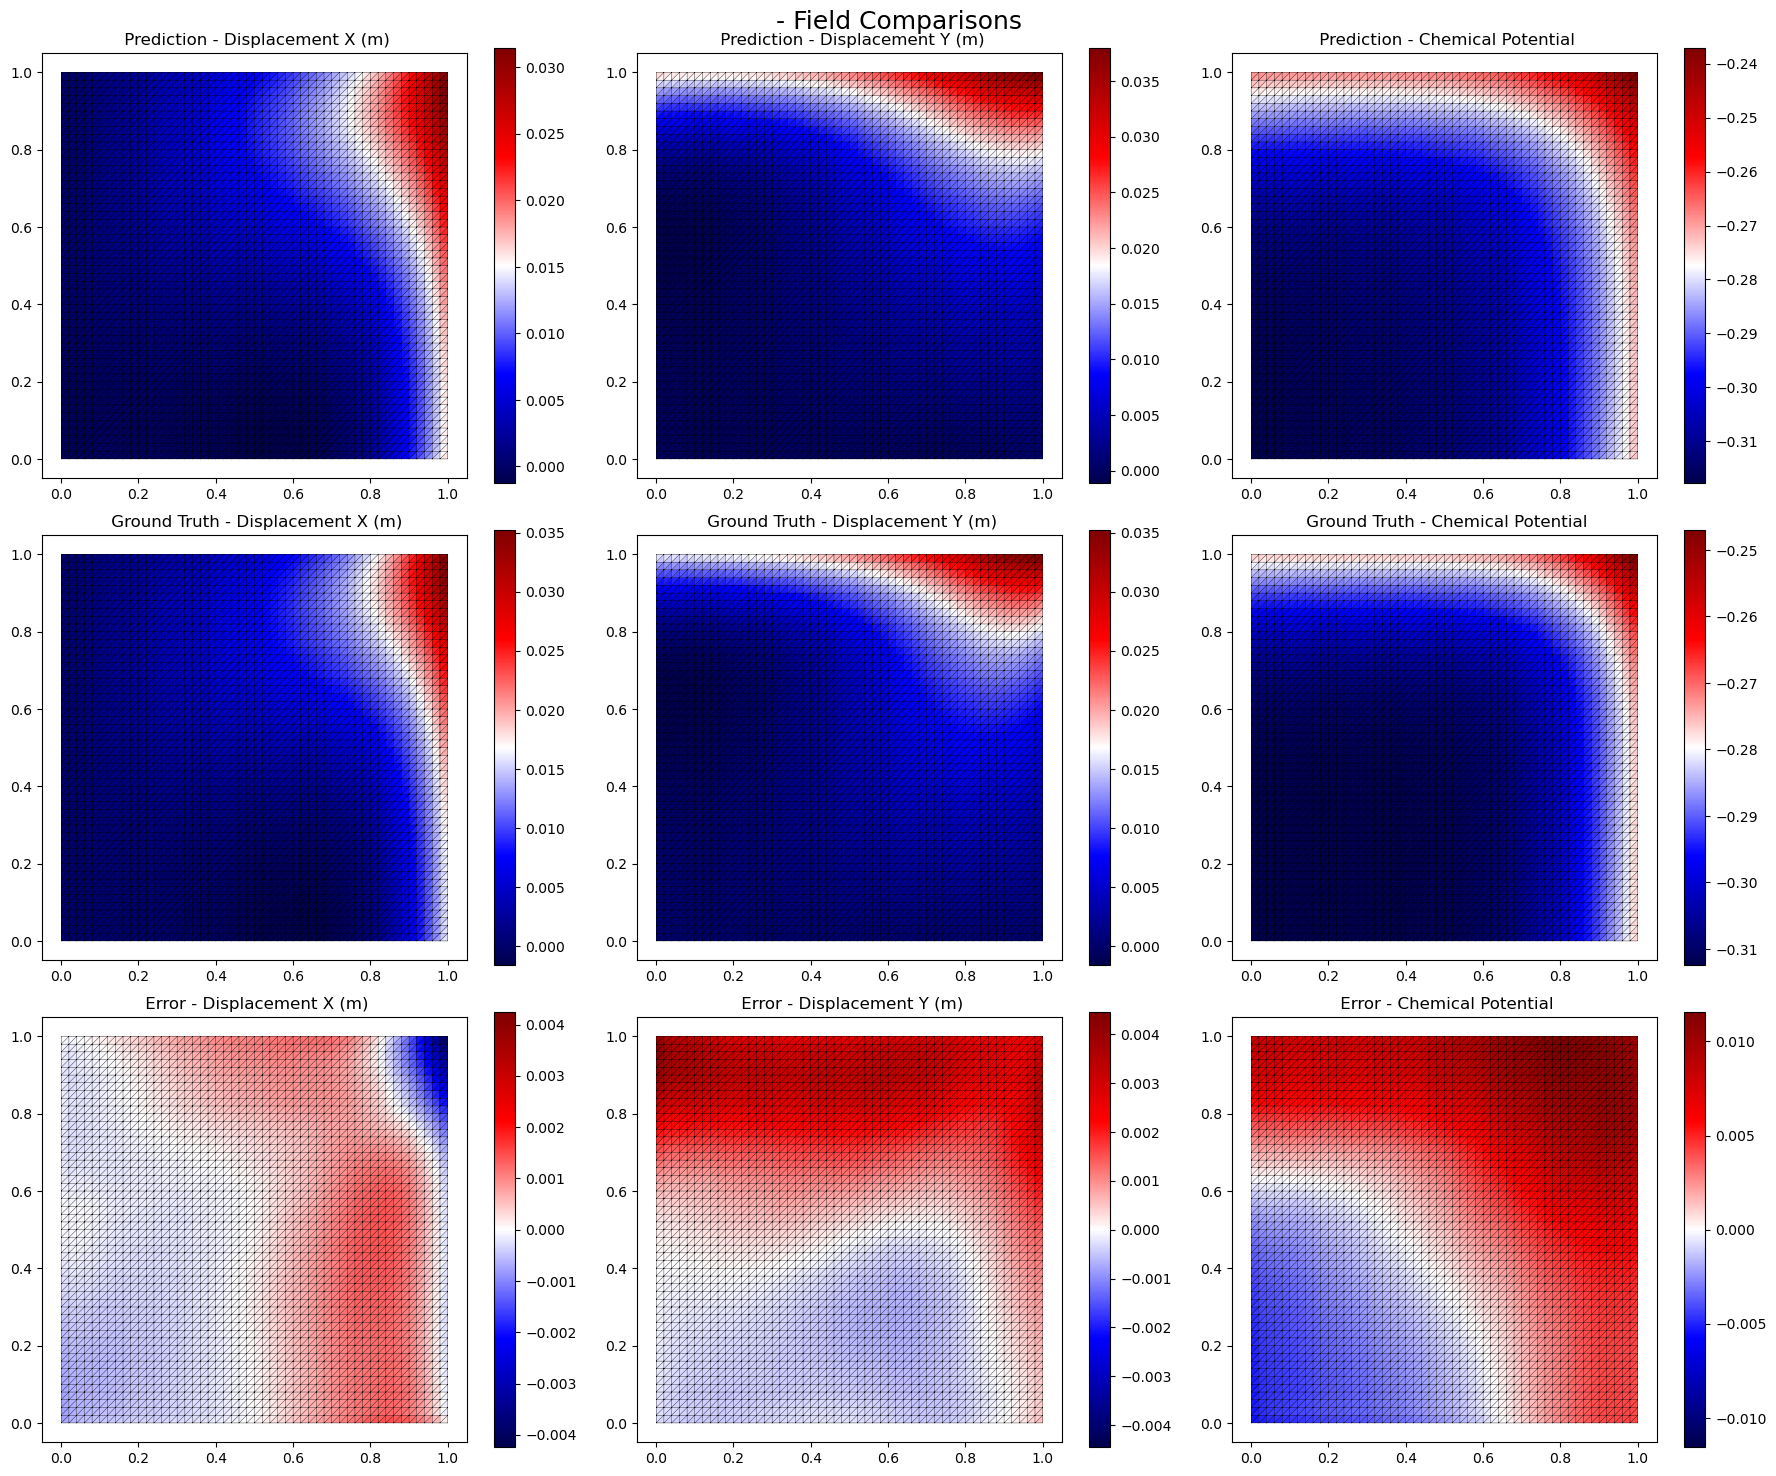

In [35]:
timestep = 49
mesh_pos = output["mesh_pos"].detach().cpu().numpy()
cells = output["cells"].detach().cpu().numpy()
pred_displacement = output["predict_displacement"][timestep].squeeze(0).detach().cpu().numpy()
gt_displacement = output["gt_displacement"][timestep].squeeze(0).detach().cpu().numpy()
pred_chem_pot = output["predict_chem_pot"][timestep].squeeze(0).detach().cpu().numpy()
gt_chem_pot = output["gt_chem_pot"][timestep].squeeze(0).detach().cpu().numpy()
plot_result(mesh_pos, cells, pred_displacement, gt_displacement, pred_chem_pot, gt_chem_pot, "")

In [26]:
pred_displacement.shape

(2601, 2)